# Train a Neural Network Regressor Using Plain PyTorch

## Import Libraries

In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
from tqdm import tqdm
from tqdm import trange
from torch.utils.tensorboard import SummaryWriter
import torch
from torch import optim
from torch import nn
from torch.nn import functional as F
from datasets.toy_datasets import ToyDatasetModule
from models.models import SimpleFeedForwardNN
import numpy as np
from time import sleep
# %matplotlib inline
import matplotlib.pyplot as plt
# from icecream import ic

## Steps to Create and Train a Neural Network with PyTorch

1. Check your computation hardware (CPU / GPU / TPU... available?)
2. Setup your dataset
3. Create your neural network
4. Define a loss function
5. Neural network train loop 5 steps:

   ```python
      for (x, y) in dataloader:  # training loop 
         ...
         ...
         ...

   ```
   1. Make a prediction with your model (neural network):
   $$\hat{y} = model(x)$$
      
   2. Compute the loss (prediction error), e.g., using Mean Square Error (MSE) loss:
   $$\mathcal{loss}(\hat{y}, y_{true}) = L = \{ l_1, ..., l_N \}^{T}, \space l_n = (\hat{y}_{n} - y_{n})^{2}$$
   $$L \space \text{is the batch loss, where:}$$
   $$N \space \space \text{is the number of samples in a batch}$$
   $$n\space\space\text{represents the number of elements in each tensor (dimensions)}$$

   3. Zero $\nabla$ params - zero gradients for every batch
      ```python
         optimizer.zero_grad()
      ```
   4. Compute and accumulate $\nabla$ params
      ```python
         loss.backward()
      ```
   5. Step in towards $-\nabla$ params
      ```python
         optimizer.step()

### Check Hardware Devices

Check the available hardware computation devices (ideally we would like to have a GPU).

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Get Dataset

In [4]:
dataset_train_val_module = ToyDatasetModule(dataset_name="ToyDataset1",
                                            num_samples=6000,
                                            xt_range=[-1, 1],
                                            noise_coef=0.3,
                                            batch_size=32,
                                            valid_size=0.4,
                                            seed=10)

Dataset name:  ToyDataset1
Dataset length:  6000
Dataset random seed:  10


Create dataset and get train and validation loaders

In [5]:
dataset_train_val_module.setup()
train_loader = dataset_train_val_module.get_train_dataloader()
valid_loader = dataset_train_val_module.get_valid_dataloader()

Compute Train and Validation Loader length

In [6]:
print("Train Loader Length: {} batches with {} samples each".format(len(train_loader), dataset_train_val_module.batch_size))
print("Validation Loader Length: {} batches with {} samples each".format(len(valid_loader), dataset_train_val_module.batch_size))

Train Loader Length: 113 batches with 32 samples each
Validation Loader Length: 75 batches with 32 samples each


### Create a Simple Neural Network 

In [7]:
class SimpleFeedForwardNN(nn.Module):
    def __init__(self, input_dim: int = 1, output_val_dim: int = 1):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 32)  # 1st layer of weights
        self.fc2 = nn.Linear(32, 16)  # 2nd layer of weights
        self.mean = nn.Linear(16, output_val_dim)  # final layer to add an extra linear transformation

    def forward(self, x):
        
        x = self.fc1(x)
        x = F.relu(x)
        
        x = self.fc2(x)
        x = F.relu(x)
        
        output_mean = self.mean(x)

        return output_mean

In [8]:
model = SimpleFeedForwardNN()

### Define the Loss Function

In [9]:
mse_loss = nn.MSELoss(reduction='mean')

### Create the optimizer

In [10]:
optimizer = optim.Adam(model.parameters(),  # specify your model (neural network) parameters (weights)
                       lr=0.001,  # learning rate
                       weight_decay=1e-5,  # L2 penalty regularizer
                       eps=1e-7)  # adds numerical numerical stability (avoids division by 0)

In [11]:
epochs = 30
seed = 10

# use a (pseudo) random seed for PyTorch random number generator - required for reproducibility!!!
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
else:
    torch.manual_seed(seed)

In [12]:
torch.cuda.empty_cache() # PyTorch thing

model.to(device)  # send model to device (gpu if available)

epoch_train_losses, epoch_val_losses = [], []

t_epochs = tqdm(range(epochs), total=epochs, leave=False, unit="epochs")  # for aesthetic training progress visualization

for epoch in t_epochs:
    ################
    #     Train    #
    ################
    model.train()  # put model in train mode!
    train_loss = 0.0
    epoch_mean_train_loss = 0.0
    
    train_batches = tqdm(enumerate(train_loader), total=len(train_loader), leave=False, unit="batch")
    for batch_idx, (x_b, y_b) in train_batches:
        x_b = torch.unsqueeze(x_b, 1)
        x_b = x_b.to(device)
        y_b = torch.unsqueeze(y_b, 1)
        y_b = y_b.to(device)

        # Zero your gradients for every batch!
        optimizer.zero_grad()
        # Make predictions for this batch
        y_pred = model(x_b)        
        # Compute the loss and its gradients
        mse_loss_val = mse_loss(y_pred, y_b)
        mse_loss_val.backward()
        # Adjust learning weights
        optimizer.step()
        
        train_loss += mse_loss_val.item()  # accumulate training batch loss
        # sleep(0.01)

    epoch_mean_train_loss = train_loss / (len(train_batches))
    
    #####################
    #        Test       #
    #####################
    model.eval()  # put model in evaluation mode!
    valid_loss = 0.0
    epoch_mean_valid_loss = 0.0
    
    with torch.no_grad():
        valid_batches = tqdm(enumerate(valid_loader), total=len(valid_loader), leave=False, unit="batch")
        for i, (x_b, y_b) in valid_batches:
            x_b = torch.unsqueeze(x_b, 1)
            x_b = x_b.to(device)
            y_b = torch.unsqueeze(y_b, 1)
            y_b = y_b.to(device)

            y_pred = model(x_b)     
            mse_loss_val = mse_loss(y_pred, y_b)
            valid_loss += mse_loss_val.item()  # accumulate validation batch loss

    epoch_mean_valid_loss = valid_loss / (len(valid_batches))

    t_epochs.set_description(f"Epoch [{epoch} / {epochs}]")
    t_epochs.set_postfix({'train_loss': epoch_mean_train_loss, 'valid_loss': epoch_mean_valid_loss})
    
    epoch_train_losses.append(epoch_mean_train_loss)
    epoch_val_losses.append(epoch_mean_valid_loss)
    
    sleep(0.01)

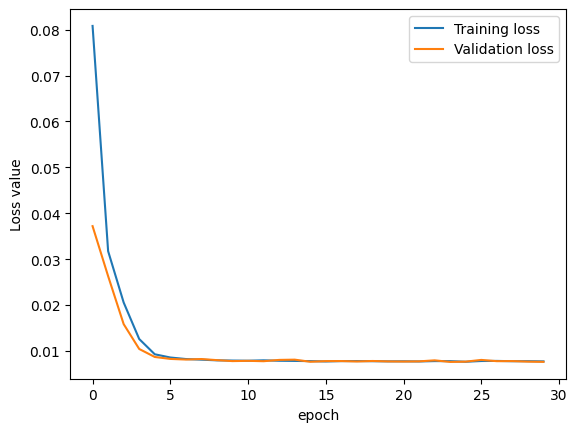

In [13]:
plt.plot(epoch_train_losses, label='Training loss')
plt.plot(epoch_val_losses, label='Validation loss')
plt.ylabel("Loss value")
plt.xlabel("epoch")
plt.legend(frameon=True)
plt.show()

## Make Predictions

### Create a Test dataset

Dataset name:  ToyDataset1
Dataset length:  600
Dataset random seed:  10


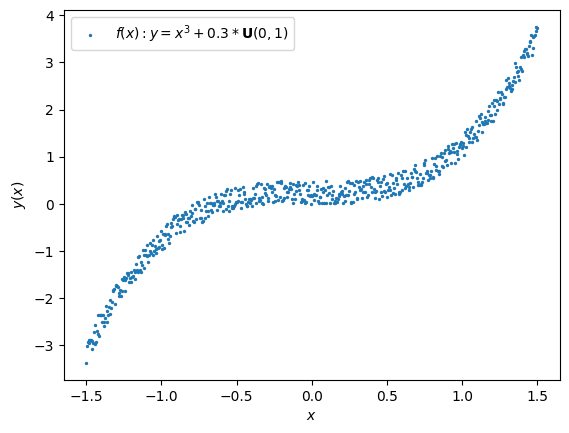

In [24]:
dataset_test_module = ToyDatasetModule(dataset_name="ToyDataset1",
                                       num_samples=600,  # we need a fraction of samples
                                       xt_range=[-1.5, 1.5],  # increase x values interval
                                       noise_coef=0.5,  # change the noise coefficient
                                       batch_size=32,
                                       valid_size=0.0,
                                       seed=10)

dataset_test_module.dataset.plot_dataset()

### Send data to the trained Neural Network

In [26]:
input_tensor = torch.Tensor(dataset_test_module.dataset.xt)
input_tensor.shape

torch.Size([600, 1])

In [27]:
input_tensor = input_tensor.to(device)
y_hat = model(input_tensor)
y_hat.shape

torch.Size([600, 1])

In [30]:
y_hat_np = y_hat.cpu().detach().numpy()  # Move to CPU, detach computation graph, and transpor to numpy
y_hat_np.shape

(600, 1)

### Show Predictions

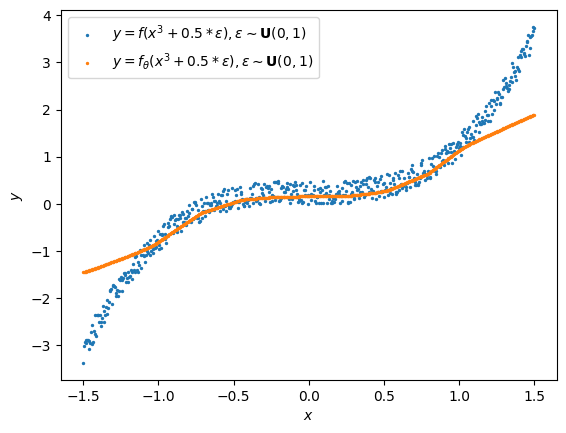

In [42]:
plt.scatter(dataset_test_module.dataset.xt, dataset_test_module.dataset.yt, s=2, label=r"$y = f(x^{3} + 0.5 * \epsilon), \epsilon \sim \mathbf{U}(0, 1)$")
plt.scatter(dataset_test_module.dataset.xt, y_hat_np, s=2, label=r"$y = f_{\theta}(x^{3} + 0.5 * \epsilon), \epsilon \sim \mathbf{U}(0, 1)$")
plt.ylabel("$y$")
plt.xlabel("$x$")
plt.legend()
plt.show()